<a href="https://colab.research.google.com/github/jibook/git-remote/blob/master/TensorFlow_15_Deep_Learning_for_text_and_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import os 
data_dir = './'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv') 

In [ ]:
f = open(fname)
data = f.read()
f.close() 
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:] 

In [ ]:
import numpy as np 
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines): 
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean

In [ ]:
std = float_data[:20000].std(axis=0)

In [ ]:
float_data /= std

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [ ]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [ ]:
from keras.models import Sequential
from keras import layers 
from tensorflow.keras.optimizers import RMSprop 

model = Sequential() 
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(1)) 

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 748s 1s/step - loss: 1.5410 - val_loss: 0.7355
Epoch 2/20
500/500 [==============================] - 694s 1s/step - loss: 0.4566 - val_loss: 0.3827
Epoch 3/20
500/500 [==============================] - 748s 1s/step - loss: 0.3371 - val_loss: 0.3697
Epoch 4/20
500/500 [==============================] - 748s 1s/step - loss: 0.3138 - val_loss: 0.3568
Epoch 5/20
500/500 [==============================] - 747s 1s/step - loss: 0.2967 - val_loss: 0.3583
Epoch 6/20
500/500 [==============================] - 748s 1s/step - loss: 0.2885 - val_loss: 0.3756
Epoch 7/20
500/500 [==============================] - 748s 1s/step - loss: 0.2812 - val_loss: 0.3805
Epoch 8/20
500/500 [==============================] - 748s 1s/step - loss: 0.2776 - val_loss: 0.3718
Epoch 9/20
500/500 [==============================] - 748s 1s/step - loss: 0.2685 - val_loss: 0.3836
Epoch 10/20
500/500 [==============================] - 748s 1s/step - loss: 0.2681 - val_loss: 0.3761


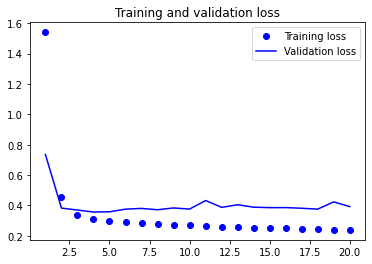

In [ ]:
import matplotlib.pyplot as plt 
loss = history.history['loss']
val_loss = history.history['val_loss'] 
epochs = range(1, len(loss) + 1)
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend() 
plt.show()